# Learning About Differencing with OpenTopography

This notebook is a compilation of resources and code snippets I am using to learn how to conduct topographic differencing within OpenTopography's framework. [OpenTopography](https://opentopography.org) (Crosby et al., 2020) provides public access to high-resolution topographic datasets and processing tools. I'll be drawing heavily from their bank of [webinars](https://www.youtube.com/@OpenTopography), [workshops](https://opentopography.org/learn/workshops) and [code repositories](https://github.com/OpenTopography), as well as from other sources that I will highlight along the way.

## Background on differencing

https://www.youtube.com/watch?v=SHXzFGGUEZI

Compare (pre)
Reference (post)

Difference = Reference - Compare

Need identical grid for pre and post event topography

## Data querying

I can get the USGS 3DEP data directly on the OpenTopography [website](https://portal.opentopography.org/dataCatalog?group=usgs) and this process is described in this OT [tutorial](https://www.youtube.com/watch?v=AouYvcVIxvc). Dataset landing page provides some basic metadata (total number of points, survey area, point density, survey date, data publication date) and link to full metadata hosted by USGS with with XMLs for all of the LAS files, as well as to [USGS/Entwine](https://usgs.entwine.io) site. However, many of the USGS metadata links appear to be broken (e.g., this [one](https://rockyweb.usgs.gov/vdelivery/Datasets/Staged/Elevation/LPC/Projects/USGS_LPC_MI_16Co_Osceola_2015_LAS_2018/metadata/) or this [one](https://rockyweb.usgs.gov/vdelivery/Datasets/Staged/Elevation/LPC/Projects/USGS_LPC_KS_Area2_B3_2012_LAS_2016/metadata/)). I'm guessing this has something to do with the data being migrated to the AWS platform. OT offers the opportunity to select the data download area on a map, with possibility of satellite view and a usage heat map.

The Entwine dataset has been standardized and reprojected in Web Mercator (ESPG:3857), which can have area distortions, so OT calculates local UTM zone of dataset and provides that as output option. OT records the vertical datums. Users can classify by ground and can exclude noise. Output format is in LAZ (much better compression ratio) and LAS. Offer TIN and local gridding for DEM generation. 

In [ ]:
ot_website_path="./vertical_differencing_OT_website"

To access the 3DEP data programmatically, I'm trying to follow the procedure outlined by [Hobu, Inc](https://github.com/hobuinc/usgs-lidar) and in Scott et al. (2022) and use the open source software [Entwine](https://entwine.io/en/latest/download.html) to access the USGS 3DEP Lidar Point Clouds in the form of Entwine Point Tiles (EPT), which are lossless datastructures that provide JSON-based metadata and [LASzip](https://laszip.org)-based compressed encoding. 

https://www.youtube.com/watch?v=AouYvcVIxvc

https://d9-wret.s3.us-west-2.amazonaws.com/assets/palladium/production/s3fs-public/media/files/Lidar%20Point%20Cloud%20in%20AWS%20-%20Requester%20Pays%20Instructions_v2.pdf

https://registry.opendata.aws/usgs-lidar/

https://www.usgs.gov/news/technical-announcement/usgs-3dep-lidar-point-cloud-now-available-amazon-public-dataset

https://usgs.entwine.io

I want to experiment with using the metadata available on the [Registry of Open Data on AWS](https://registry.opendata.aws/usgs-lidar/) to filter the data by survey date, overlapping areas, etc. They provide a [catalog](https://usgs-lidar-stac.s3-us-west-2.amazonaws.com/ept/catalog.json) with links to all of the lidar data entries. 

In [138]:
%%time
import requests
import json

URL = "https://usgs-lidar-stac.s3-us-west-2.amazonaws.com/ept/catalog.json"
catalog_ept=["https://s3-us-west-2.amazonaws.com/usgs-lidar-stac/ept/catalog.json"]

response = requests.get(URL)
data = response.json()

ept_links = [link['href'] for link in data.get('links', []) if '.json' in link.get('href', '')]
ept_links = list(set([link['href'] for link in data.get('links', [])])-set(catalog_ept)) #remove catalog entries to just keep lidar data entries

CPU times: user 53.3 ms, sys: 8.15 ms, total: 61.4 ms
Wall time: 493 ms


In [139]:
%%time
import concurrent.futures

# Making a dictionary to store the content of each link
link_contents = {}

def fetch_content(link):
    try:
        response = requests.get(link)
        # Make sure the request was successful
        if response.status_code == 200:
            return link, json.loads(response.text) # makes sure that the data loads as sub-keys in the dictionary, not as string
        else:
            print(f"Failed to fetch content from {link}. Status code: {response.status_code}")
            return link, None
    except requests.RequestException as e:
        print(f"Error fetching content from {link}. Error: {e}")
        return link, None

# Tried making sequential HTTP requests, took forever, so using 'concurrent.futures.ThreadPoolExecutor' to use threading to fetch content in parallel.
with concurrent.futures.ThreadPoolExecutor() as executor:
    for link, content in executor.map(fetch_content, ept_links):
        if content:
            link_contents[link] = content

CPU times: user 38.9 s, sys: 2.75 s, total: 41.6 s
Wall time: 38.7 s


In [140]:
%%time
# Saving metadata dictionary to JSON file 
with open('ept_metadata.json', 'w') as file:
    json.dump(link_contents, file)

CPU times: user 1.01 s, sys: 11.6 ms, total: 1.02 s
Wall time: 1.02 s


In [353]:
%%time
import pandas as pd
import geopandas as gpd
from shapely import Point, Polygon, MultiPoint, MultiPolygon, LineString
import numpy as np

#Adding the bounding box info in the form of shapely polygon, to see which datasets are likely to overlap
bbox_p1=[Point(tuple([link_contents[ept_links[a]]['bbox'][0],link_contents[ept_links[a]]['bbox'][1]])) for a in range(0,len(ept_links))]
bbox_p2=[Point(tuple([link_contents[ept_links[a]]['bbox'][0],link_contents[ept_links[a]]['bbox'][3]])) for a in range(0,len(ept_links))]
bbox_p3=[Point(tuple([link_contents[ept_links[a]]['bbox'][2],link_contents[ept_links[a]]['bbox'][3]])) for a in range(0,len(ept_links))]
bbox_p4=[Point(tuple([link_contents[ept_links[a]]['bbox'][2],link_contents[ept_links[a]]['bbox'][1]])) for a in range(0,len(ept_links))]
bbox=pd.Series([Polygon([bbox_p1[a],bbox_p2[a],bbox_p3[a],bbox_p4[a]]) for a in range(0,len(ept_links))],name='geometry') 

#Getting dataset id
datset_id=pd.Series([link_contents[ept_links[a]]['id'] for a in range(0,len(ept_links))],name='id')

#Getting some basic info on base and projected crs, might not use at this point
dataset_proj=pd.Series([link_contents[ept_links[a]]['properties']['proj:epsg'] for a in range(0,len(ept_links))],name='proj_espj')
dataset_base_crs_authority=pd.Series([link_contents[ept_links[a]]['properties']['proj:projjson']['base_crs']['id']['authority'] for a in range(0,len(ept_links))],name='base_crs_authority')
dataset_base_crs_code=pd.Series([link_contents[ept_links[a]]['properties']['proj:projjson']['base_crs']['id']['code'] for a in range(0,len(ept_links))],name='base_crs_code')
dataset_base_crs_name=pd.Series([link_contents[ept_links[a]]['properties']['proj:projjson']['base_crs']['name'] for a in range(0,len(ept_links))],name='base_crs_name')

usgs_3dep_bbox= gpd.GeoDataFrame(datset_id,geometry=bbox)

CPU times: user 158 ms, sys: 2.07 ms, total: 161 ms
Wall time: 160 ms


In [354]:
usgs_3dep_bbox.head()

,id,geometry
0,NE_SouthernNE_B4A_2018,"POLYGON ((-98.76028 40.68829, -98.76028 41.404..."
1,CO_SanLuisJuanMiguel_4_2020,"POLYGON ((-108.01497 37.75775, -108.01497 38.7..."
2,MN_SibleyCo_2010,"POLYGON ((-94.67364 44.42607, -94.67364 44.725..."
3,USGS_LPC_NM_NRCS_Central_A2_2017_LAS_2018,"POLYGON ((-106.39592 34.21060, -106.39592 35.1..."
4,NV_Humboldt_1_2021,"POLYGON ((-119.90158 40.46504, -119.90158 41.4..."


In [355]:
%%time
# For each dataset, I want to find the other datasets that are likely to be good candidates for differencing based on overlap in bounding boxes.

#find spatial join between all bounding boxes
join = gpd.sjoin(usgs_3dep_bbox, usgs_3dep_bbox, how="inner", predicate='intersects')
join=join.sort_values(by='index_right')

# find unique overlapping pairs
overlapping_pairs = join[join['id_left'] != join['id_right']][['id_left', 'id_right']]
t_list=list(overlapping_pairs['id_right'])
ordered_list=[i for n, i in enumerate(t_list) if i not in t_list[:n]]
matches=pd.Series([list(overlapping_pairs['id_left'][overlapping_pairs['id_right']==a]) for a in ordered_list],name='matches')
match_id=pd.Series(ordered_list,name='id')
overlap=pd.DataFrame([matches,match_id]).transpose()
usgs_3dep_bbox=usgs_3dep_bbox.merge(overlap, on='id', how='left')
usgs_3dep_bbox.head()

CPU times: user 4.27 s, sys: 11.2 ms, total: 4.28 s
Wall time: 4.28 s


,id,geometry,matches
0,NE_SouthernNE_B4A_2018,"POLYGON ((-98.76028 40.68829, -98.76028 41.404...","[NE_Northeast_Phase2_2_2020, USGS_LPC_NE_MO_El..."
1,CO_SanLuisJuanMiguel_4_2020,"POLYGON ((-108.01497 37.75775, -108.01497 38.7...","[USGS_LPC_CO_MesaCo_QL2_2015_LAS_2017, USGS_LP..."
2,MN_SibleyCo_2010,"POLYGON ((-94.67364 44.42607, -94.67364 44.725...","[MN_RenvilleCo_2010, MN_SEDriftless_5_2021, US..."
3,USGS_LPC_NM_NRCS_Central_A2_2017_LAS_2018,"POLYGON ((-106.39592 34.21060, -106.39592 35.1...","[USGS_LPC_NM_NRCS_Central_A1_2017_LAS_2018, US..."
4,NV_Humboldt_1_2021,"POLYGON ((-119.90158 40.46504, -119.90158 41.4...","[NV_WestCentralEarthMRI_5_2020, NV_WestCentral..."


In [360]:
%%time
# Going back to my Minnesota example, let me find the matches for USGS LPC MN Arrowhead B1 2011 LAS 2016.

list(usgs_3dep_bbox['matches'][usgs_3dep_bbox['id']=='USGS_LPC_MN_Arrowhead_B1_2011_LAS_2016'])

CPU times: user 3.31 ms, sys: 1.29 ms, total: 4.6 ms
Wall time: 4.66 ms


[['WI_Bayfield_TL_2016',
  'USGS_LPC_MN_Arrowhead_B4_2011_LAS_2016',
  'MN_FullState',
  'MN_RainyLake_1_2020',
  'MN_LakeSuperior_2_2021',
  'USGS_LPC_MN_Arrowhead_B3_2011_LAS_2016',
  'MN_LakeSuperior_1_2021',
  'USGS_LPC_WI_Bayfield_2016',
  'USGS_LPC_MN_Arrowhead_B5_2011_LAS_2016']]

I can see my desired reference dataset (MN_LakeSuperior_1_2021) in the list of results. I'll now use the AWS Command Line Interface to download the two point cloud datasets.

In [373]:
#inspect the file structure in the bucket
!aws s3 ls --no-sign-request s3://usgs-lidar-public/USGS_LPC_MN_Arrowhead_B1_2011_LAS_2016/

                           PRE ept-backup/
                           PRE ept-data/
                           PRE ept-hierarchy/
                           PRE ept-sources/
2019-01-17 13:35:23       7680 boundary.json
2018-12-24 14:38:34       2252 ept-1.json
2018-12-24 14:38:09       2244 ept-10.json
2018-12-24 14:38:11       2244 ept-11.json
2018-12-24 14:38:12       2244 ept-12.json
2018-12-24 14:40:27       2252 ept-13.json
2018-12-24 14:38:38       2244 ept-14.json
2018-12-24 14:38:39       2244 ept-15.json
2018-12-24 14:40:06       2252 ept-16.json
2018-12-24 14:39:39       2251 ept-17.json
2018-12-24 14:39:36       2244 ept-18.json
2018-12-24 14:40:52       2252 ept-19.json
2018-12-24 14:36:36       2244 ept-2.json
2018-12-24 14:40:39       2251 ept-20.json
2018-12-24 14:40:08       2244 ept-21.json
2018-12-24 14:40:10       2244 ept-22.json
2018-12-24 14:43:08       2252 ept-23.json
2018-12-24 14:40:29       2244 ept-24.json
2018-12-24 14:43:29       2252 ept-25.json
2018-12-2

In [ ]:
# Unsure how the hierarchy works/the coordinate system is set up?

## Processing point cloud data

I worked through OT's [Intro to PDAL](https://github.com/OpenTopography/Intro_to_PDAL) tutorial. Add examples with pipelines. 

## Visualizing point clouds

https://usgs.entwine.io

## Gridding point cloud data

[Intro to PDAL](https://github.com/OpenTopography/Intro_to_PDAL)

## Processing raster data

## Visualizing DTMs and DSMs

In [456]:
%%time
import rasterio as rio
from osgeo import gdal

#paths for compare (MN Arrowhead B1 2011 LAS 2016) and reference (MN LakeSuperior 1 2021) folders
path_mn_comp='./DTMs/NDuluth/USGS LPC MN Arrowhead B1 2011 LAS 2016/'
path_mn_ref='./DTMs/NDuluth/MN LakeSuperior 1 2021/'

#TIF files for OT TIN-generated DTMs
tif_ot_comp=path_mn_comp+'output.tin.tif'
tif_ot_ref=path_mn_ref+'output.tin.tif'

def import_raster(path1):
    # Open the DTM raster files
    with rio.open(path1) as src1:
        dtm1 = src1.read(1)  # Read the first band of the raster
    return (dtm1,src1)
(dtm_ot_comp,src1)=import_raster(tif_ot_comp)
(dtm_ot_ref,src2)=import_raster(tif_ot_ref)

CPU times: user 2.31 s, sys: 205 ms, total: 2.51 s
Wall time: 2.58 s


In [453]:
print(f"CRS for compare dataset:{src1.crs}.")
print(f"CRS for reference dataset:{src2.crs}.")

CRS for compare dataset:EPSG:32615.
CRS for reference dataset:EPSG:32615.


In [454]:
full_extent1 = [src1.bounds.left, src1.bounds.right, src1.bounds.bottom, src1.bounds.top]
full_extent2 = [src2.bounds.left, src2.bounds.right, src2.bounds.bottom, src2.bounds.top]

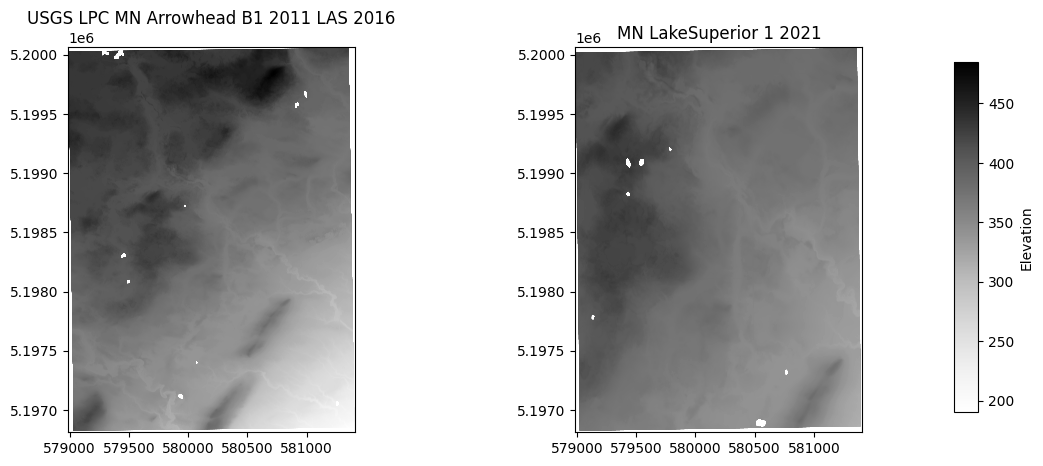

In [464]:
# Determine global min and max for consistent color scaling
vmin = np.min([dtm_array_comp[dtm_array_comp>0].min(),dtm_array_ref[dtm_array_ref>0].min()]) 
vmax = np.max([dtm_array_comp.max(), dtm_array_ref.max()])

# Plot the DEMs side by side with consistent color scaling
fig, axa = plt.subplots(1, 2, figsize=(12, 5))

# Display DEM1
axa[0].imshow(dtm_array_comp, cmap='Grays', extent=full_extent1, vmin=vmin, vmax=vmax)
axa[0].set_title('USGS LPC MN Arrowhead B1 2011 LAS 2016')

# Display DEM2
axa[1].imshow(dtm_array_ref, cmap='Grays', extent=full_extent2, vmin=vmin, vmax=vmax)
axa[1].set_title('MN LakeSuperior 1 2021')

# Add a colorbar to the side
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
fig.colorbar(axa[0].imshow(dtm_array_comp, cmap='Grays', extent=full_extent1, vmin=vmin, vmax=vmax), cax=cbar_ax, label='Elevation')

plt.show()

## Vertical differencing

In [458]:
out_comp="./vertical_differencing_OT_website/NDuluth/try1/vertical_differencing/output.compare.tif"
out_ref="./vertical_differencing_OT_website/NDuluth/try1/vertical_differencing/output.reference.tif"
vert_diff="./vertical_differencing_OT_website/NDuluth/try1/vertical_differencing/vertical_differencing.tif"

(dtm_comp,src1)=import_raster(out_comp)
(dtm_ref,src2)=import_raster(out_ref)
(diff,src3)=import_raster(vert_diff)

full_extent1 = [src1.bounds.left, src1.bounds.right, src1.bounds.bottom, src1.bounds.top]
full_extent2 = [src2.bounds.left, src2.bounds.right, src2.bounds.bottom, src2.bounds.top]
full_extent3 = [src3.bounds.left, src3.bounds.right, src3.bounds.bottom, src3.bounds.top]

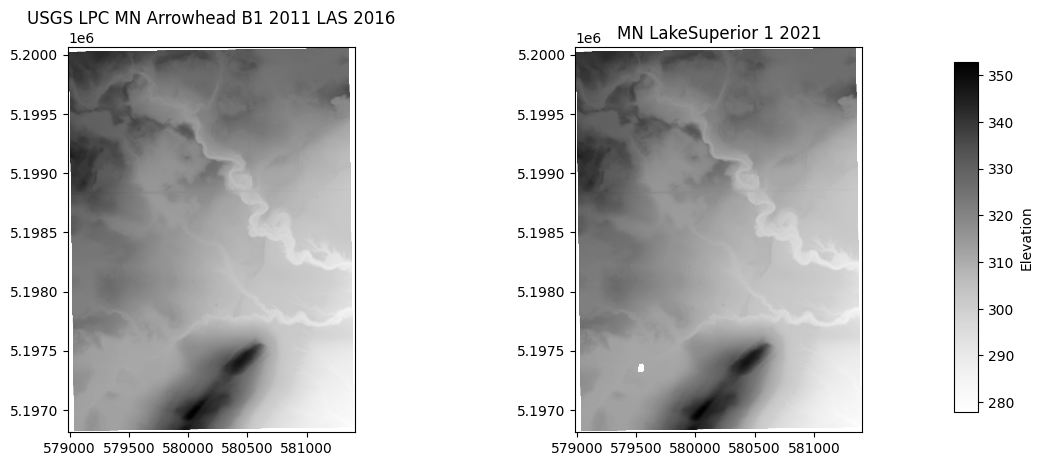

In [463]:
# Determine global min and max for consistent color scaling
vmin = np.min([dtm_comp[dtm_comp>0].min(),dtm_ref[dtm_ref>0].min()]) 
vmax = np.max([dtm_comp.max(), dtm_ref.max()])

# Plot the DEMs side by side with consistent color scaling
fig, axa = plt.subplots(1, 2, figsize=(12, 5))

# Display DEM1
axa[0].imshow(dtm_comp, cmap='Grays', extent=full_extent1, vmin=vmin, vmax=vmax)
axa[0].set_title('USGS LPC MN Arrowhead B1 2011 LAS 2016')

# Display DEM2
axa[1].imshow(dtm_ref, cmap='Grays', extent=full_extent2, vmin=vmin, vmax=vmax)
axa[1].set_title('MN LakeSuperior 1 2021')

# Add a colorbar to the side
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
fig.colorbar(axa[0].imshow(dtm_comp, cmap='Grays', extent=full_extent1, vmin=vmin, vmax=vmax), cax=cbar_ax, label='Elevation')

plt.show()

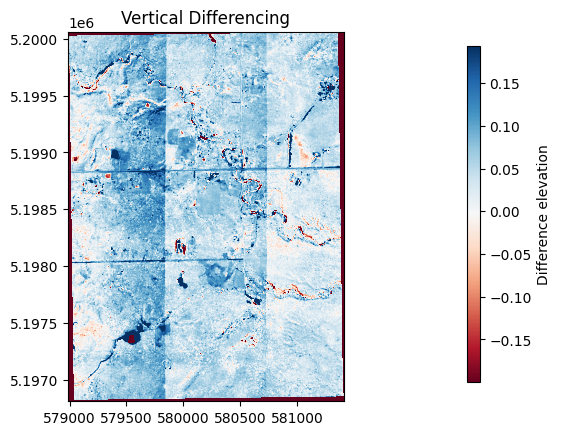

In [479]:
## The OT differencing result 
vmin = np.min(diff[diff>-0.2]) 
vmax = np.max(diff[diff<0.2])

fig, ax = plt.subplots()
ax.imshow(diff, cmap='bwr', extent=full_extent3, vmin=vmin, vmax=vmax)
ax.set_title('Vertical Differencing')

cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
fig.colorbar(ax.imshow(diff, cmap='RdBu', extent=full_extent3, vmin=vmin, vmax=vmax), cax=cbar_ax, label='Difference elevation')

In [470]:
np.min(diff[diff>-2]) 

-1.9995728

## 3D differencing

## Handling error

#### References

Crosby, C. J., Arrowsmith, J. R., & Nandigam, V. (2020). Zero to a trillion: Advancing Earth surface process studies with open access to high-resolution topography. In Developments in Earth Surface Processes (Vol. 23, pp. 317-338). Elsevier.

Scott, C. P., Beckley, M., Phan, M., Zawacki, E., Crosby, C., Nandigam, V., & Arrowsmith, R. (2022). Statewide USGS 3DEP lidar topographic differencing applied to Indiana, USA. Remote Sensing, 14(4), 847.